==================================Sentiment Analysis and the Dataset============================

In [3]:
import os
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
#@save
d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz',
                          '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [5]:
#@save
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0) # Positive review: 1, negative review: 0
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

# trainings: 25000
label: 1 review: Bromwell High is a cartoon comedy. It ran at the same time a
label: 1 review: Homelessness (or Houselessness as George Carlin stated) has 
label: 1 review: Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


In [6]:
train_tokens = d2l.tokenize(train_data[0], token='word') # train_tokens is a list of list of words
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
len(train_tokens), len(vocab)

(25000, 49347)

In [7]:
train_tokens[0]

['Bromwell',
 'High',
 'is',
 'a',
 'cartoon',
 'comedy.',
 'It',
 'ran',
 'at',
 'the',
 'same',
 'time',
 'as',
 'some',
 'other',
 'programs',
 'about',
 'school',
 'life,',
 'such',
 'as',
 '"Teachers".',
 'My',
 '35',
 'years',
 'in',
 'the',
 'teaching',
 'profession',
 'lead',
 'me',
 'to',
 'believe',
 'that',
 'Bromwell',
 "High's",
 'satire',
 'is',
 'much',
 'closer',
 'to',
 'reality',
 'than',
 'is',
 '"Teachers".',
 'The',
 'scramble',
 'to',
 'survive',
 'financially,',
 'the',
 'insightful',
 'students',
 'who',
 'can',
 'see',
 'right',
 'through',
 'their',
 'pathetic',
 "teachers'",
 'pomp,',
 'the',
 'pettiness',
 'of',
 'the',
 'whole',
 'situation,',
 'all',
 'remind',
 'me',
 'of',
 'the',
 'schools',
 'I',
 'knew',
 'and',
 'their',
 'students.',
 'When',
 'I',
 'saw',
 'the',
 'episode',
 'in',
 'which',
 'a',
 'student',
 'repeatedly',
 'tried',
 'to',
 'burn',
 'down',
 'the',
 'school,',
 'I',
 'immediately',
 'recalled',
 '.........',
 'at',
 '..........',


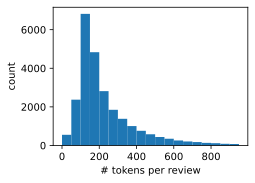

In [8]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

In [9]:
num_steps = 500  # sequence length
train_features = torch.tensor([d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [10]:
vocab[train_tokens[0]]

[5340,
 9314,
 32452,
 17311,
 21339,
 22513,
 9854,
 39622,
 19076,
 45586,
 41329,
 46003,
 18931,
 43275,
 36880,
 39044,
 17366,
 41572,
 33446,
 44618,
 18931,
 3681,
 12255,
 3454,
 49197,
 31580,
 45586,
 45286,
 39004,
 33220,
 34457,
 46106,
 19905,
 45556,
 5340,
 3681,
 41374,
 32452,
 35482,
 22235,
 46106,
 39840,
 45544,
 32452,
 3681,
 15821,
 41633,
 46106,
 44892,
 3681,
 45586,
 31998,
 44388,
 48604,
 21142,
 41831,
 40859,
 45925,
 45610,
 37496,
 3681,
 3681,
 45586,
 3681,
 36449,
 45586,
 48616,
 42773,
 18139,
 40321,
 34457,
 36449,
 45586,
 41582,
 9590,
 32913,
 18388,
 45610,
 44390,
 16863,
 9590,
 41419,
 45586,
 26693,
 31580,
 48562,
 17311,
 44384,
 40381,
 46606,
 46106,
 20946,
 25595,
 45586,
 41574,
 9590,
 31424,
 39912,
 2103,
 19076,
 3681,
 9317,
 3693,
 22073,
 33560,
 3681,
 9595,
 30538,
 46106,
 41234,
 36633,
 36449,
 49280,
 45284,
 3681,
 16802,
 46106,
 5340,
 9317,
 9590,
 27178,
 45556,
 34256,
 17809,
 36449,
 35636,
 17959,
 45759,
 

In [11]:
num_steps = 500  # sequence length
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [12]:
# create data iterators. At each iteration, a minibatch of 64 examples are returned.
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


In [13]:
#@save
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, is_train=True)
    test_data = read_imdb(data_dir, is_train=False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),batch_size,is_train=False)
    return train_iter, test_iter, vocab

====================================Sentiment Analysis: Using Recurrent Neural Networks===============================

![as](./Images/GloVeRNN.png)

In [14]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [15]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [16]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights);

In [17]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [18]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [19]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

IndexError: list index out of range

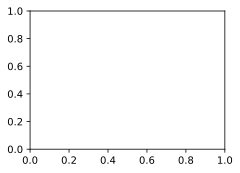

In [ ]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

# make sure you gave gpu, otherwise it will crash with list index out of range
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
#@save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')

======================================Sentiment Analysis: Using Convolutional Neural Networks=======================

![GloVE attention](./Images/GloveAttention.png)

In [22]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

![1d cross-correlation](./Images/corr1d.png)

In [ ]:

def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

In [ ]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

![1d cross-correlation](./Images/corr1d-multi-in.png)

In [ ]:
def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

Note that multi-input-channel one-dimensional cross-correlations are equivalent to single-input-channel two-dimensional cross-correlations.

![1d cross-correlation](./Images/corr2d.png)


![text CNN](./Images/textCNN.png)

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        # shape: (batch size, 2*embed_size, no. of tokens)
        embeddings = embeddings.permute(0, 2, 1) 
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        # encoding shape: (batch size, sum(num_channels))
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [ ]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

In [ ]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

======================================Natural Language Inference and the Dataset===========================================

**Natural language inference** studies whether a hypothesis can be inferred from a premise, where both are a text sequence. In other words, natural language inference determines the logical relationship between a pair of text sequences. Such relationships usually fall into three types:

Entailment: the hypothesis can be inferred from the premise.

Contradiction: the negation of the hypothesis can be inferred from the premise.

Neutral: all the other cases.

In [ ]:
import os
import re
import torch
from torch import nn
from d2l import torch as d2l

#@save
d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

In [ ]:
#@save
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""
    def extract_text(s):
        # Remove information that will not be used by us
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # Substitute two or more consecutive whitespace with space
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [ ]:
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

In [ ]:
# The following shows that the three labels “entailment”, “contradiction”, and “neutral” are balanced in both the training set and the testing set.

test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

In [ ]:
#@save
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

In [ ]:
#@save
def load_data_snli(batch_size, num_steps=50):
    """Download the SNLI dataset and return data iterators and vocabulary."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

In [ ]:
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

===================================Natural Language Inference: Using Attention===================================

![GloVE attention](./Images/GloveAttention.png)

![Natural Language Interfernce using Attention](./Images/NeutralLanguageInferenceWithAttention.png)

#### Natural Language Inference — Using Attention

##### Overview
Natural Language Inference (NLI) determines the logical relationship between a **premise** sentence and a **hypothesis** sentence. The decomposable attention model (Parikh et al., 2016) is a lightweight architecture that achieves strong NLI performance using only feed-forward networks and attention, without recurrent or convolutional layers.

The model has three main steps:
1. **Attend** — compute soft alignments between tokens in the premise and hypothesis.
2. **Compare** — compare each token with its aligned representation using an MLP.
3. **Aggregate** — pool comparison vectors and classify the relation (entailment / contradiction / neutral).

##### Notation
- Premise: $\mathbf{A} = (\mathbf{a}_1, \dots, \mathbf{a}_m)$
- Hypothesis: $\mathbf{B} = (\mathbf{b}_1, \dots, \mathbf{b}_n)$
- Token vectors: $\mathbf{a}_i, \mathbf{b}_j \in \mathbb{R}^d$
- $[\,\cdot\,,\,\cdot\,]$ denotes concatenation.
- $f, g, h$ denote learned feed-forward networks (MLPs).

##### 1) Attending (alignment)
"Attending" = figuring out which words in one sentence should match or align with which words in the other.

Compute unnormalized attention scores between every premise token $\mathbf{a}_i$ and hypothesis token $\mathbf{b}_j$: $e_{ij} = f(\mathbf{a}_i)^\top f(\mathbf{b}_j)$
where $f$ is an MLP applied to each token vector.

Normalize to obtain attention weights and aligned vectors:

- For each premise token $\mathbf{a}_i$:
  - the attended hypothesis representation: $\boldsymbol{\beta}_i = \sum_{j=1}^n \text{softmax}(e_{ij})\, \mathbf{b}_j = \sum_{j=1}^n \frac{\exp(e_{ij})}{\sum_{k=1}^n \exp(e_{ik})}\, \mathbf{b}_j$
  - $\boldsymbol{\beta}_i$ = "What the hypothesis says that corresponds to the i-th premise token"
  - For each premise word $\mathbf{a}_i$, the model asks: "Which hypothesis words relate to me, and how strongly?" Then it produces a weighted average of all hypothesis word vectors

- For each hypothesis token $\mathbf{b}_j$:
  - the attended premise representation: $\boldsymbol{\alpha}_j = \sum_{i=1}^m \text{softmax}(e_{ij})\, \mathbf{a}_i = \sum_{i=1}^m \frac{\exp(e_{ij})}{\sum_{k=1}^m \exp(e_{kj})}\, \mathbf{a}_i$
  - $\boldsymbol{\alpha}_j$ = "What the premise says that corresponds to the j-th hypothesis token"

**Computational trick (decomposability):** Evaluate $f(\cdot)$ independently on each token, making the model effectively linear in $m+n$ for the precomputations rather than quadratic.

##### 2) Comparing
Compare each token with its attended counterpart using another MLP $g$:

- For premise tokens: $\mathbf{v}_{A,i} = g\big([\mathbf{a}_i,\, \boldsymbol\beta_i]\big), \quad i=1,\dots,m$
- For hypothesis tokens: $\mathbf{v}_{B,j} = g\big([\mathbf{b}_j,\, \boldsymbol\alpha_j]\big), \quad j=1,\dots,n$

##### 3) Aggregating (pooling & classification)
Aggregate (sum) the comparison vectors:

$\mathbf{v}_A = \sum_{i=1}^m \mathbf{v}_{A,i}, \qquad
\mathbf{v}_B = \sum_{j=1}^n \mathbf{v}_{B,j}$

Concatenate and pass through a final classifier MLP $h$:

$\hat{\mathbf{y}} = h\big([\mathbf{v}_A,\, \mathbf{v}_B]\big)$

The output $\hat{\mathbf{y}}$ represents scores or probabilities over the NLI labels (entailment, contradiction, neutral).

##### Training details (as described in the chapter)
- Dataset: SNLI (Stanford Natural Language Inference).
- Embeddings: Pretrained GloVe vectors used to initialize word representations.
- Typical hyperparameters reported: batch size 256, sequence length capped (e.g., 50), trained for a few epochs.
- Reported accuracy in the chapter's example: approximately $82.8\\%$ on SNLI with a short training run.

##### Key takeaways
- The decomposable attention model is simple yet effective: no RNNs/CNNs, only MLPs + attention.
- Attention provides soft alignment between premise and hypothesis tokens, enabling cross-sentence comparisons.
- Decomposability reduces computation while preserving performance.
- Pretrained embeddings significantly help model convergence and performance.
- Limitations: simpler models may miss long-range context or order-dependent nuances; improvements often come from richer encoders or contextualized embeddings.

##### Further exercises (from the chapter)
- Extend the model with richer inputs (e.g., contextualized embeddings such as BERT).
- Try alternative pooling strategies (max, mean, attention-weighted pooling).
- Analyze failure cases where order or broader context matters.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [3]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B, `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B, `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # e is attention weights
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A, no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # shape of F.softmax(e, dim=-1): (batch_size, no. of tokens in sequence A, no. of tokens in sequence B)
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A, `embed_size`),
        # where sequence B is softly aligned with each token (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B, `embed_size`),
        # where sequence A is softly aligned with each token (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

In [4]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

In [5]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    # shape of V_A: (batch_size, no. of tokens in sequence A, num_hiddens)
    # shape of V_B: (batch_size, no. of tokens in sequence B, num_hiddens)
    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        # shape of V_A: (batch_size, num_hiddens)
        # shape of V_B: (batch_size, num_hiddens)
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [6]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100, num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [7]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

OSError: [Errno 22] Invalid argument: '..\\data\\snli_1.0\\Icon\r'

In [ ]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

In [ ]:
#@save
def split_batch_multi_inputs(X, y, devices):
    """Split multi-input `X` and `y` into multiple devices."""
    X = list(zip(*[gluon.utils.split_and_load(
        feature, devices, even_split=False) for feature in X]))
    return (X, gluon.utils.split_and_load(y, devices, even_split=False))

In [ ]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
#@save
def predict_snli(net, vocab, premise, hypothesis):
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

In [ ]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

=====================================Fine-Tuning BERT for Sequence-Level and Token-Level Applications=====================================

Sequence-level application:
- Single Text Classification
- Text Pair Classification or Regression

Token-level:
- Text Tagging
- Question Answering

===============================Natural Language Inference: Fine-Tuning BERT====================================

![BERT-MLP](./Images/BertMLP.png)

In [12]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

In [13]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [14]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_blks, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(
        len(vocab), num_hiddens, ffn_num_hiddens=ffn_num_hiddens, num_heads=4,
        num_blks=2, dropout=0.2, max_len=max_len)
    # Load pretrained BERT parameters
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [ ]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_blks=2, dropout=0.1, max_len=512, devices=devices)

In [ ]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [ ]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.LazyLinear(3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [ ]:
net = BERTClassifier(bert)

In [ ]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
net(next(iter(train_iter))[0])
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)